In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

71


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,373ff2579f48876d532f530f24d9e66e60ea18ae,sworn-bolo,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.7,cot/format-think.txt,cq.txt,cot-2-shot.json,...,0.506827,0.613350,0.585463,0.688149,0.456579,0.577615,0.358025,0.449177,COT,2
1,584d87c35ef38c1f478a02f6cc8b9e64e49fb872,woods-seep,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.7,cot/format-think.txt,cq.txt,cot-2-shot.json,...,0.500621,0.610851,0.571885,0.685572,0.444737,0.564511,0.385185,0.466823,COT,2
2,77051b1c1af71012dd5797b302501da507941c21,gamer-lift,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.7,cot/format-think.txt,cq.txt,cot-2-shot.json,...,0.515929,0.621607,0.577476,0.689049,0.488158,0.591096,0.377778,0.470374,COT,2
3,5272ba34055f580f68728a739745c0a827076cd8,focal-ewes,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.7,cot/format-minimal.txt,cq.txt,cot-2-shot.json,...,0.529582,0.641826,0.596645,0.703818,0.475000,0.604902,0.424691,0.519478,COT,2
4,73fa4473d96469d7e789cc290b6c137e6f6b5bf9,filar-smut,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.5,cot/format-think.txt,cq.txt,cot-2-shot.json,...,0.510964,0.619385,0.587859,0.699666,0.459211,0.572871,0.370370,0.458498,COT,2


In [3]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "name",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [4]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)

In [5]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,params.run
17,Direct,direct/helpful-output-format-few.txt,cq.txt,direct-2-shot.json,0.3,"(1, 2)"


In [6]:
def remove_ext(filename):
    return filename.split(".", 1)[0]

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(remove_ext)
df["params.qa.user_prompt_template"] = df["params.qa.user_prompt_template"].map(remove_ext)
df["params.qa.few_shot_examples"] = df["params.qa.few_shot_examples"].map(remove_ext)

In [7]:
df[target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False).head(10)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
33,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.7,0.639222,0.753153,0.665335,0.770206,0.650000,0.781398,0.538272,0.647436
37,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.1,0.642118,0.749716,0.666134,0.766545,0.648684,0.776322,0.555556,0.647764
41,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.3,0.636326,0.748966,0.661342,0.767986,0.646053,0.774351,0.540741,0.642532
31,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.638808,0.748716,0.658946,0.762757,0.657895,0.781491,0.540741,0.643805
32,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.639222,0.748642,0.662141,0.765277,0.656579,0.784169,0.535802,0.630546
39,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.3,0.639636,0.748071,0.663738,0.765736,0.656579,0.778543,0.533333,0.636282
36,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.1,0.639636,0.747852,0.661342,0.765014,0.650000,0.773138,0.553086,0.647349
29,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.3,0.636740,0.747799,0.661342,0.764182,0.647368,0.779041,0.540741,0.638527
30,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.636326,0.746978,0.663738,0.768304,0.644737,0.768149,0.535802,0.641325
42,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.5,0.634257,0.746677,0.658946,0.765879,0.644737,0.772841,0.538272,0.638221


In [8]:
df['params.qa.system_prompt'].unique()

array(['cot/format-minimal', 'cot/format-think',
       'cte/excellent-format-few', 'direct/helpful-output-format-few',
       'direct/minimal-output-format-few'], dtype=object)

In [9]:
avg_df = df.groupby(target_param_cols)[metric_cols].mean().reset_index()
avg_df.head()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
0,COT,cot/format-minimal,cq,cot-2-shot,0.1,0.536478,0.644726,0.602769,0.711864,0.491228,0.607840,0.416461,0.506396
1,COT,cot/format-minimal,cq,cot-2-shot,0.3,0.537305,0.644080,0.602236,0.709179,0.493860,0.608937,0.418107,0.508783
2,COT,cot/format-minimal,cq,cot-2-shot,0.5,0.535237,0.643000,0.597178,0.706385,0.495175,0.611807,0.418930,0.505592
3,COT,cot/format-minimal,cq,cot-2-shot,0.7,0.526272,0.638634,0.592918,0.703872,0.480263,0.603905,0.406584,0.502132
4,COT,cot/format-think,cq,cot-2-shot,0.1,0.521445,0.627994,0.592119,0.698853,0.470175,0.585013,0.399177,0.489599


In [10]:
# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)
best_df

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
10,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.638119,0.748112,0.661608,0.765446,0.653070,0.777937,0.537449,0.638559
17,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.3,0.605296,0.717382,0.642572,0.748738,0.587500,0.715008,0.523457,0.624903
0,COT,cot/format-minimal,cq,cot-2-shot,0.1,0.536478,0.644726,0.602769,0.711864,0.491228,0.607840,0.416461,0.506396


## Visualizations

In [11]:
def prepare_data(dataf):
    # Simplify column names for use in formula
    dataf = dataf[target_param_cols + ['params.run'] + metric_cols[:2]].rename(
        columns={
            col: col.replace("params.qa.", "").replace("params.", "").replace("metrics.", "")
            for col in dataf.columns
        }
    )

    # Combine prompts into a single column for simplicity
    dataf["prompt"] = (
        dataf["system_prompt"]
        + " | "
        + dataf["user_prompt_template"]
        + " | "
        + dataf["few_shot_examples"].map(str)
    )

    return dataf


In [12]:
def plot_variance(dataf, figsize=(12, 8), legend='auto', legend_loc='lower left'):  
    plt.figure(figsize=figsize)
    sns.lineplot(x='temperature', y='f1', hue='prompt', data=dataf, linewidth=2.5, legend=legend)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    if legend:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

In [13]:
prepared_df = prepare_data(df)
temperature_mask = prepared_df["temperature"] <= 1.0
zero_shot_mask = prepared_df["few_shot_examples"] == 'empty'
prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
0,COT,cot/format-minimal,cq,cot-2-shot,0.1,1,0.534961,0.641767,cot/format-minimal | cq | cot-2-shot
1,COT,cot/format-minimal,cq,cot-2-shot,0.1,2,0.537029,0.645778,cot/format-minimal | cq | cot-2-shot
2,COT,cot/format-minimal,cq,cot-2-shot,0.1,3,0.537443,0.646634,cot/format-minimal | cq | cot-2-shot
3,COT,cot/format-minimal,cq,cot-2-shot,0.3,1,0.533719,0.640558,cot/format-minimal | cq | cot-2-shot
4,COT,cot/format-minimal,cq,cot-2-shot,0.3,2,0.542822,0.648676,cot/format-minimal | cq | cot-2-shot
...,...,...,...,...,...,...,...,...,...
66,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.5,2,0.593711,0.712103,direct/minimal-output-format-few | cq | direct...
67,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.5,3,0.599090,0.711090,direct/minimal-output-format-few | cq | direct...
68,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.7,1,0.594125,0.709393,direct/minimal-output-format-few | cq | direct...
69,Direct,direct/minimal-output-format-few,cq,direct-2-shot,0.7,2,0.586678,0.706467,direct/minimal-output-format-few | cq | direct...


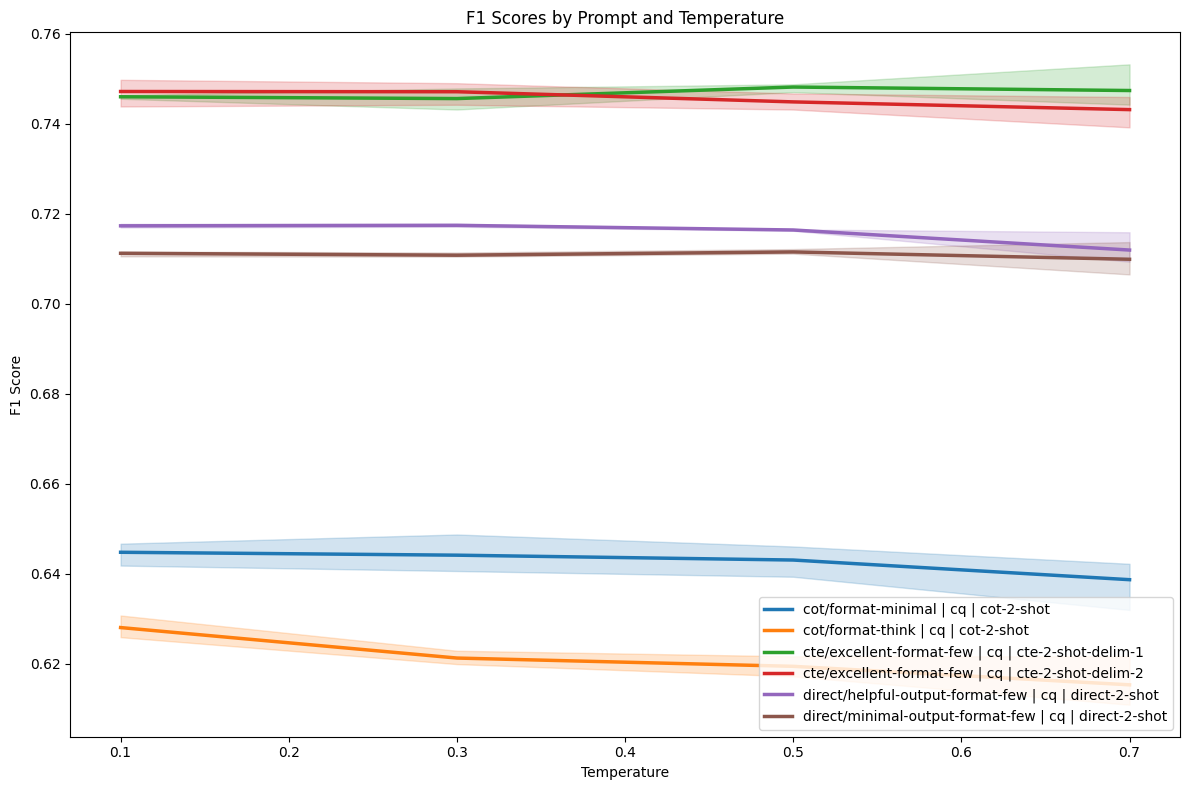

In [14]:
plot_variance(prepared_df, legend_loc='lower right')

## Statistical Testing

In [15]:
def two_way_anova(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform Two-Way ANOVA with replication
    formula = "f1 ~ C(prompt) + C(temperature) + C(prompt):C(temperature)"
    model = ols(formula, data=dataf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results:")
    print(anova_table)


def one_way_anova_by_temperature(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf["temperature"].unique()
    for temp in temperatures:
        temp_data = dataf[dataf["temperature"] == temp]
        grouped = temp_data.groupby("prompt")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

In [16]:
def report(dataf, alpha=0.005):
    print("Prompt values")
    for prompt in dataf.prompt.unique():
        print("\t", prompt)
    print("\n")
    print("Temperature values: ", ', '.join([f"{t:.1f}" for t in dataf.temperature.unique()]))
    print("\n")
    # Two-Way ANOVA
    two_way_anova(dataf)
    print("\n")
    
    # One-Way ANOVA by Temperature
    one_way_anova_by_temperature(dataf)
    print("\n")
    
    # Tukey’s HSD
    tukey = pairwise_tukeyhsd(endog=dataf['f1'], groups=dataf['prompt'], alpha=alpha)
    print(tukey)

### Direct technique

In [17]:
direct_prompt_mask = prepared_df["technique"] == "Direct"
direct_prompt_prepared_df = prepared_df[direct_prompt_mask & temperature_mask]
direct_prompt_prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
48,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,1,0.605296,0.717192,direct/helpful-output-format-few | cq | direct...
49,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,2,0.608192,0.717716,direct/helpful-output-format-few | cq | direct...
50,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.1,3,0.608192,0.716897,direct/helpful-output-format-few | cq | direct...
51,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.3,1,0.604468,0.717065,direct/helpful-output-format-few | cq | direct...
52,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.3,2,0.606123,0.717698,direct/helpful-output-format-few | cq | direct...
53,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.5,1,0.599504,0.716174,direct/helpful-output-format-few | cq | direct...
54,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.5,2,0.604055,0.716409,direct/helpful-output-format-few | cq | direct...
55,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.5,3,0.604882,0.716454,direct/helpful-output-format-few | cq | direct...
56,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.7,1,0.598676,0.710515,direct/helpful-output-format-few | cq | direct...
57,Direct,direct/helpful-output-format-few,cq,direct-2-shot,0.7,2,0.600745,0.715841,direct/helpful-output-format-few | cq | direct...


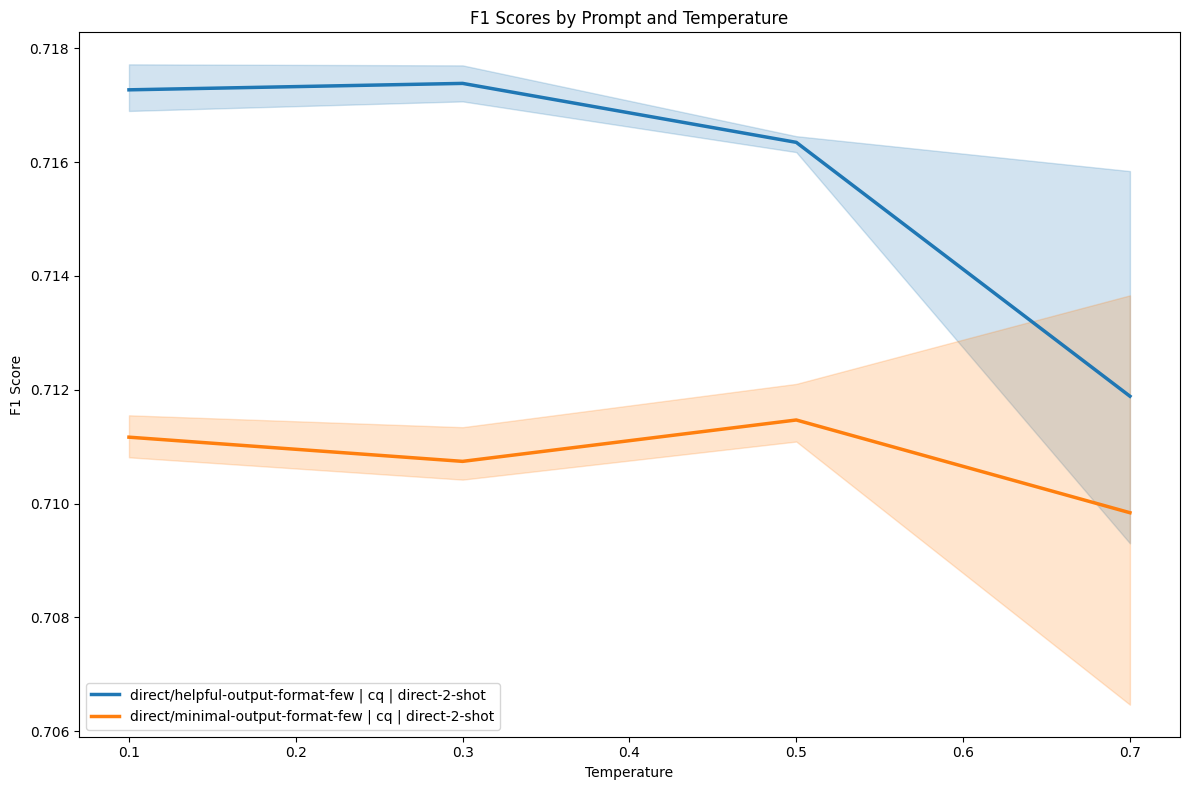

In [18]:
plot_variance(direct_prompt_prepared_df, legend='brief')

In [19]:
report(direct_prompt_prepared_df)

Prompt values
	 direct/helpful-output-format-few | cq | direct-2-shot
	 direct/minimal-output-format-few | cq | direct-2-shot


Temperature values:  0.1, 0.3, 0.5, 0.7


Two-Way ANOVA Results:
                            sum_sq    df          F    PR(>F)
C(prompt)                 0.000133   1.0  37.716911  0.000019
C(temperature)            0.000044   3.0   4.194371  0.024216
C(prompt):C(temperature)  0.000018   3.0   1.703329  0.209051
Residual                  0.000053  15.0        NaN       NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 215.4761, p-value: 1.2532e-04
One-Way ANOVA for Temperature 0.3:
F-statistic: 214.0827, p-value: 6.9238e-04
One-Way ANOVA for Temperature 0.5:
F-statistic: 217.6484, p-value: 1.2287e-04
One-Way ANOVA for Temperature 0.7:
F-statistic: 0.4990, p-value: 5.1892e-01


                                               Multiple Comparison of Means - Tukey HSD, FWER=0.01                                                
                        group1      

In [20]:
# Tukey’s HSD
_data = direct_prompt_prepared_df.loc[~zero_shot_mask]
tukey = pairwise_tukeyhsd(endog=_data['f1'], groups=_data['prompt'], alpha=0.005)
print(tukey)


                                               Multiple Comparison of Means - Tukey HSD, FWER=0.01                                                
                        group1                                                group2                        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------------------------------------
direct/helpful-output-format-few | cq | direct-2-shot direct/minimal-output-format-few | cq | direct-2-shot  -0.0048 0.0001 -0.0078 -0.0017   True
--------------------------------------------------------------------------------------------------------------------------------------------------


## COT

In [21]:
cot_prompt_mask = prepared_df["technique"] == "COT"
cot_prompt_prepared_df = prepared_df[cot_prompt_mask & temperature_mask]

In [22]:
cot_prompt_prepared_df.groupby("prompt")["f1"].mean().sort_values(ascending=False)

prompt
cot/format-minimal | cq | cot-2-shot    0.642610
cot/format-think | cq | cot-2-shot      0.620965
Name: f1, dtype: float64

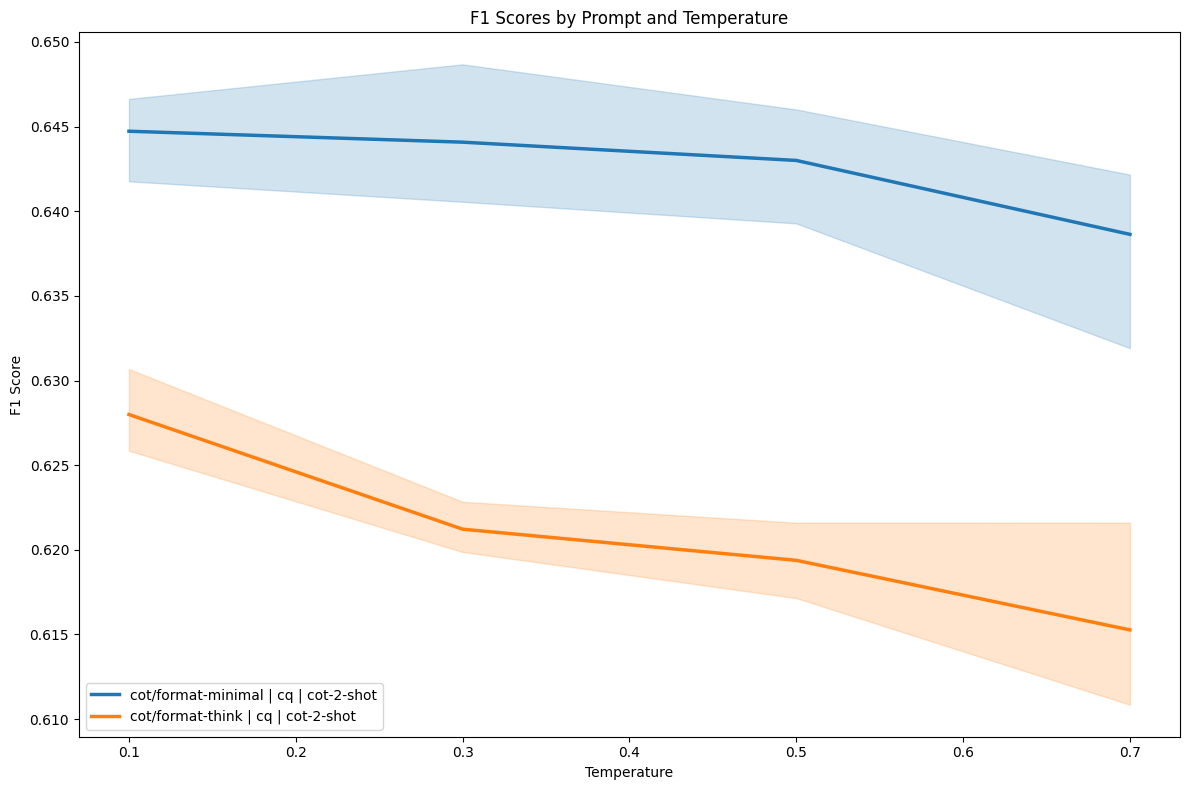

In [23]:
plot_variance(cot_prompt_prepared_df)

In [24]:
report(cot_prompt_prepared_df)

Prompt values
	 cot/format-minimal | cq | cot-2-shot
	 cot/format-think | cq | cot-2-shot


Temperature values:  0.1, 0.3, 0.5, 0.7


Two-Way ANOVA Results:
                            sum_sq    df           F        PR(>F)
C(prompt)                 0.002811   1.0  196.163292  2.127032e-10
C(temperature)            0.000272   3.0    6.335496  4.895635e-03
C(prompt):C(temperature)  0.000049   3.0    1.133180  3.654333e-01
Residual                  0.000229  16.0         NaN           NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 65.7285, p-value: 1.2584e-03
One-Way ANOVA for Temperature 0.3:
F-statistic: 80.0083, p-value: 8.6404e-04
One-Way ANOVA for Temperature 0.5:
F-statistic: 100.5328, p-value: 5.5625e-04
One-Way ANOVA for Temperature 0.7:
F-statistic: 24.9605, p-value: 7.5114e-03


                            Multiple Comparison of Means - Tukey HSD, FWER=0.01                             
               group1                              group2               meandiff p-adj

### All techniques

In [25]:
best_df['params.run'] = 0
best_prompts = prepare_data(best_df).prompt.values.tolist()
_data = prepared_df.copy()
prompt_mask = _data['prompt'].isin(best_prompts)
best_prepared_data = _data.loc[prompt_mask&temperature_mask]
best_prepared_data

,technique,system_prompt,user_prompt_template,few_shot_examples,temperature,run,exact_match,f1,prompt
0,COT,cot/format-minimal,cq,cot-2-shot,0.1,1,0.534961,0.641767,cot/format-minimal | cq | cot-2-shot
1,COT,cot/format-minimal,cq,cot-2-shot,0.1,2,0.537029,0.645778,cot/format-minimal | cq | cot-2-shot
2,COT,cot/format-minimal,cq,cot-2-shot,0.1,3,0.537443,0.646634,cot/format-minimal | cq | cot-2-shot
3,COT,cot/format-minimal,cq,cot-2-shot,0.3,1,0.533719,0.640558,cot/format-minimal | cq | cot-2-shot
4,COT,cot/format-minimal,cq,cot-2-shot,0.3,2,0.542822,0.648676,cot/format-minimal | cq | cot-2-shot
5,COT,cot/format-minimal,cq,cot-2-shot,0.3,3,0.535374,0.643005,cot/format-minimal | cq | cot-2-shot
6,COT,cot/format-minimal,cq,cot-2-shot,0.5,1,0.537857,0.646012,cot/format-minimal | cq | cot-2-shot
7,COT,cot/format-minimal,cq,cot-2-shot,0.5,2,0.532478,0.643707,cot/format-minimal | cq | cot-2-shot
8,COT,cot/format-minimal,cq,cot-2-shot,0.5,3,0.535374,0.639282,cot/format-minimal | cq | cot-2-shot
9,COT,cot/format-minimal,cq,cot-2-shot,0.7,1,0.520894,0.631911,cot/format-minimal | cq | cot-2-shot


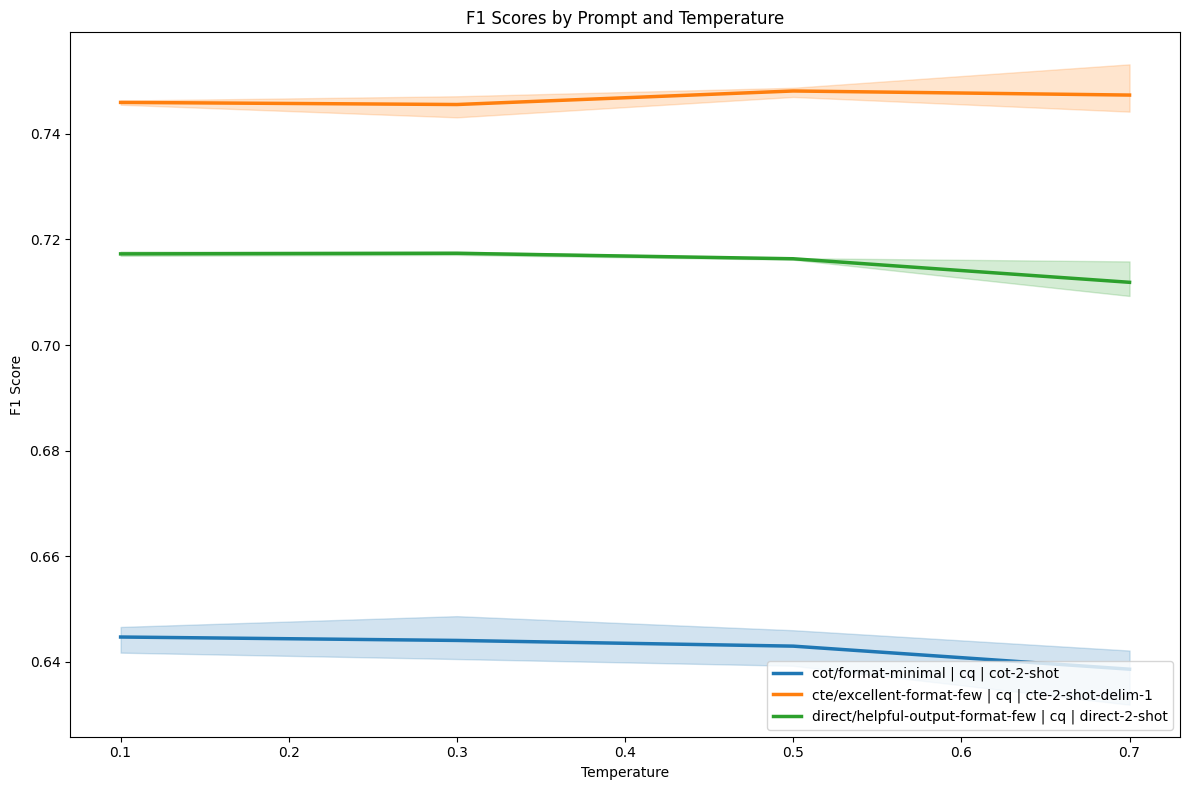

In [26]:
plot_variance(best_prepared_data, figsize=(12, 8), legend_loc='lower right')

In [27]:
report(best_prepared_data)

Prompt values
	 cot/format-minimal | cq | cot-2-shot
	 cte/excellent-format-few | cq | cte-2-shot-delim-1
	 direct/helpful-output-format-few | cq | direct-2-shot


Temperature values:  0.1, 0.3, 0.5, 0.7


Two-Way ANOVA Results:
                            sum_sq    df            F        PR(>F)
C(prompt)                 0.068344   2.0  3442.101313  3.220289e-29
C(temperature)            0.000068   3.0     2.282292  1.059788e-01
C(prompt):C(temperature)  0.000070   6.0     1.182169  3.501162e-01
Residual                  0.000228  23.0          NaN           NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 3457.9773, p-value: 6.5128e-10
One-Way ANOVA for Temperature 0.3:
F-statistic: 882.9113, p-value: 4.2363e-07
One-Way ANOVA for Temperature 0.5:
F-statistic: 2061.7674, p-value: 3.0673e-09
One-Way ANOVA for Temperature 0.7:
F-statistic: 387.0890, p-value: 4.5485e-07


                                             Multiple Comparison of Means - Tukey HSD, FWER=0.01                 

## Inspect

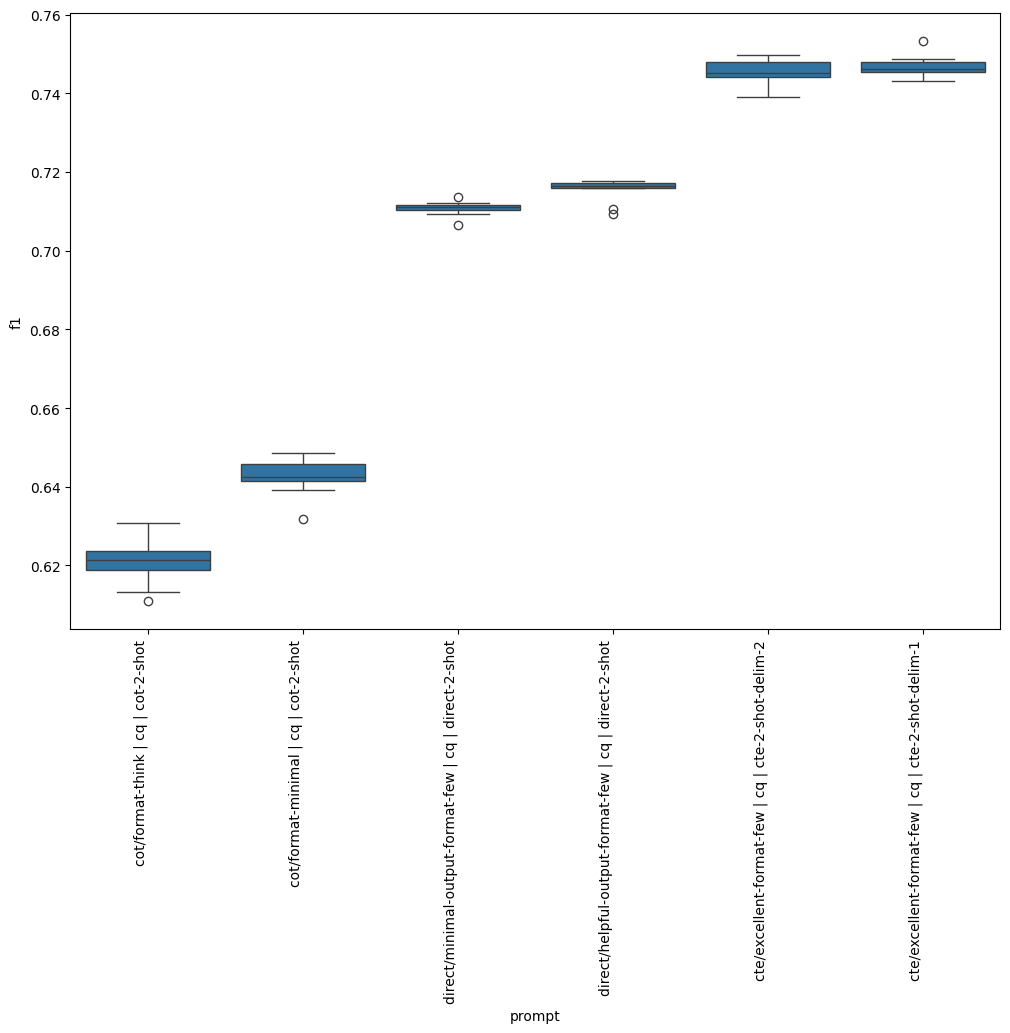

In [28]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_df.loc[temperature_mask].sort_values(by="f1"),
)
plt.xticks(rotation=90, ha="right");